# K-Armed Bandit Reinforcement Learning Experiments

**TLDR** 

For the k-armed bandit problems, we see the importance of balancing exploration and exploitation. Just because we find a good action, doesn't mean we should stick there. We should allocate some time to explore the rewards from less observed actions that could potentially give us higher rewards!

**What's the K-armed bandit problem?**

K-armed bandit problems are the simplest reinforcement learning problems. The idea is there is a set of K distributions of rewards. This distribution is unknown the the RL agent. The goal is to maximize the rewards by sampling from each distribution, much like pulling the lever of the slot machine. Except in this case there are K slot machines, and the distribution of possible winnings in each slot machine are different and unknown. The RL agent must therefore infer the distributions as it plays the game. Note that it's possible that each of the K distributions change over time. In this case, the agent must be able to adapt to this. 

Here, we experiment on the K-armed bandit problem. 

**Stationary vs non-stationary rewards**

We generated K randomly-generated Gaussian distributions of rewards, where the standard deviation is 1 and mean is taken from a Gaussian of 0 mean and 1 standard deviation. We then consider two cases:
* Stationary rewards: the reward distributions do not change over the course of the game
* Non-stationary rewards: the reward distribution means gradually change via random walk where the changes are sampled from a Gaussian with mean 0 and standard deviation 1.

**Four kinds of bandit algorithms**

We explore four kinds of bandit algorithms:
* Greedy with sample-averaging
* Greedy with weighted averaging
* Epsilon-Greedy with sample-averaging
* Espilon-Greedy with weighted averaging

**Sample-average? Weighted average?**

Sample-averaging simply means, our estimate of the expected value of each distribution is a simple mean of the collected datapoints about that distribution:

$Q = \frac{1}{N} \sum_i^N{R_i}$

Meanwhile, weighted averaging means that we place more importance on the more recent rewards in anticipation of changing distributions. The estimate of the value follows an exponentially decaying average:

$Q = (1-\alpha)^N + \sum_i^N{\alpha * (1-\alpha)^{N-i}R_i}$

$\alpha$ is a fixed "step size" parameter in contrast to sample-averaging where effectively $\alpha = 1/N(a)$ where $N(a)$ is the number of times action $a$ is selected as the game progresses.

**Greedy? Epsilon-Greedy?**

In these methods, we estimate the expected value of each of the K distributions from our experience while playing the game. We then choose the action as the one that is associated with the distribution of highest estimated expected reward, which mathematically means,

$a = \text{argmax}_aQ(a)$

This formulation is called Greedy, where always the action or "arm" in the case of K-armed bandit with the highest estimated expected reward $Q$ is chosen. However, a modification of this is called Epsilon-Greedy or $\epsilon$-Greedy where at any timestep, there is $\epsilon$ probability of choosing a random action with equal probability and $1-\epsilon$ probability of a greedy selection.

**Exploitation vs Exploration**

When we select a greedy action, we call this "exploitation" because we are maximizing our existing knowledge. Meanwhile when we select a random action regardless of past rewards, we call this "exploration" because we are exploring potentially better actions than what we have observed. There is a trade-off between these two because for a given model, it cannot explore and exploit at the same time. 

When the model exploits, it is maximizing rewards from more certain actions at the expense of losing opportunity to try potentially better actions. When a model explores, it looks for potentially good actions but miss out on the opportunity to maximize more certain good actions, while also exposing itself to risk of lower rewards.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# for visualization of animation
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")

In [2]:
# generate q*(a)
def init_q(k=10, random_q_init=True, std=1):

    # initialize means of q
    if random_q_init:
        q_mu = np.random.normal(0, std, k)
    elif not random_q_init:
        q_mu = np.zeros(k)
    return q_mu

# add random walk
def random_walk_q(q_mu, std=0.01):
    delta = np.random.normal(0, std, size=len(q_mu))
    q_mu = q_mu + delta
    return q_mu

# randomly generate N samples for visualization purposes
def viz_r_dist(k, q_mu, N=1000, ax=None):
    r_samples = np.random.normal(q_mu, 1, size=(N, k))
    r_samples = pd.DataFrame(r_samples)
    
    # visualize
    # sns.violinplot(r_samples, inner='quart', color='orange', ax=ax)
    sns.boxplot(r_samples, color='orange', ax=ax, showfliers=False)

def update_Q(Q_old, R, step_size):
    Q_new = Q_old + step_size * (R - Q_old)
    return Q_new

def get_R(q_mu, a, std=1):
    return np.random.normal(q_mu[a], std)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
# sample average
# for sample average method, step_size = 1/N(A)

class Bandit:
    def __init__(self, 
                 k_arms, 
                 eps,
                 random_q_init, 
                 stationary_q = True,
                 q_delta_std = 0.01,
                 steps = 10000,
                 step_size = "1/N",
                 random_seed = 42
                 ):
        self.k_arms = k_arms
        self.eps = eps
        self.random_q_init = random_q_init
        self.stationary_q = stationary_q
        self.q_delta_std = q_delta_std
        self.steps = steps
        self.step_size = step_size
        self.random_seed = random_seed

    def run_bandit(self):    
        np.random.seed(self.random_seed)
        
        # tracker of Q(a) and N(a)
        Q_tracker = np.zeros((self.steps, self.k_arms)) # steps x k arms
        N_tracker = np.zeros((self.steps, self.k_arms)) # steps x k arms 
        R_tracker = []
        A_tracker = []
        A_optimal_tracker = []

        # initialize q()
        self.q_mu = init_q(k=self.k_arms, random_q_init=self.random_q_init, std=1)

        for step in range(0, self.steps):
            if not self.stationary_q:
                self.q_mu = random_walk_q(self.q_mu, std=self.q_delta_std)

            exploit = np.random.choice([True, False], p = [1-self.eps, self.eps])
            if exploit:
                # greedy action based on Q
                Q_current = Q_tracker[step, :]
                a = np.random.choice(np.argwhere(Q_current == Q_current.max()).flatten())
                # a = np.argmax(Q_current)
            elif not exploit:
                # explore
                a = np.random.choice(range(self.k_arms))

            # get reward
            R = get_R(self.q_mu, a, std=1)

            # update Q_tracker and N_tracker
            N_tracker[step, a] += 1
            # copy to next step to persist
            N_tracker[step+1, :] = N_tracker[step, :]

            if self.step_size == "1/N":
                self.step_size = 1 / N_tracker[step, a]

            Q_tracker[step, a] = update_Q(Q_tracker[step, a], R, self.step_size)
            # copy to next step to persist
            Q_tracker[step+1, :] = Q_tracker[step, :]

            R_tracker += [R]
            A_tracker += [a]
            A_optimal_tracker += [np.argmax(self.q_mu)] # the correct one

            if step + 1 == self.steps - 1:
                break

        self.Q_tracker = np.array(Q_tracker)
        self.N_tracker = np.array(N_tracker)
        self.R_tracker = np.array(R_tracker)
        self.A_tracker = np.array(A_tracker)
        self.A_optimal_tracker = np.array(A_optimal_tracker)

In [4]:
def plot_learning_curves(stationary_q, random_q_init, q_delta_std,
                         step_sizes = [0.1, "1/N"], eps_list = [0, 0.1, 0.01]):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)    
    for step_size in step_sizes:    
        for eps in eps_list:

            R_vals = []
            Q_vals = []
            N_vals = []
            A_prop_correct= []

            for trial in range(n_trials):
                bandit = Bandit(k_arms, eps=eps,
                                random_q_init=random_q_init,
                                stationary_q=stationary_q, 
                                q_delta_std=q_delta_std,
                                steps=steps, step_size=step_size,
                                random_seed=trial,
                                )
                bandit.run_bandit()
                
                R_vals += [bandit.R_tracker]
                cnt_correct = (bandit.A_tracker == bandit.A_optimal_tracker)
                A_prop_correct += [cnt_correct]
                Q_vals += [bandit.Q_tracker]
                N_vals += [bandit.N_tracker]


            axs[0].plot(moving_average(np.array(R_vals).mean(axis=0), w), label=f'eps = {eps}; step_size = {step_size}')
            axs[1].plot(moving_average(np.array(A_prop_correct).mean(axis=0), w), label=f'eps = {eps}; step_size = {step_size}')

    axs[0].set_title("Average Return")
    axs[1].set_title("Percent Optimal Actions")

    axs[0].set_xlabel("timestep")
    axs[0].set_ylabel(f"average return (MA-{w})")

    axs[1].set_xlabel("timestep")
    axs[1].set_ylabel(f"pct optimal actions (MA-{w})")

    # axs[0].set_ylim(0, 4)
    # axs[1].set_ylim(0, 1)

    axs[0].legend()

    plt.suptitle(f"Stationary q: {stationary_q}")
    plt.tight_layout()
    sns.despine()

## Experiments

We summarize below our experiment parameters. There are 50 arms or distributions of rewards. Each game has 20,000 timesteps. For our analysis we run 500 trials or independent runs of the game, the results of which we average. The standard deviation for sampling how much we change the means of the K reward distributions for the non-stationary problem is 0.01.

In [5]:
k_arms = 30 # number of levers / arms
steps = 20000 # count steps in an episode
n_trials = 500 # number of independent runs/trials
q_delta_std = 0.1 # standard deviation of the Gaussian used for random walk on the true q() values


### Stationary Problem

Below is an example of K randomly generated distributions of rewards for the K-armed bandit problem with fixed reward distributions.

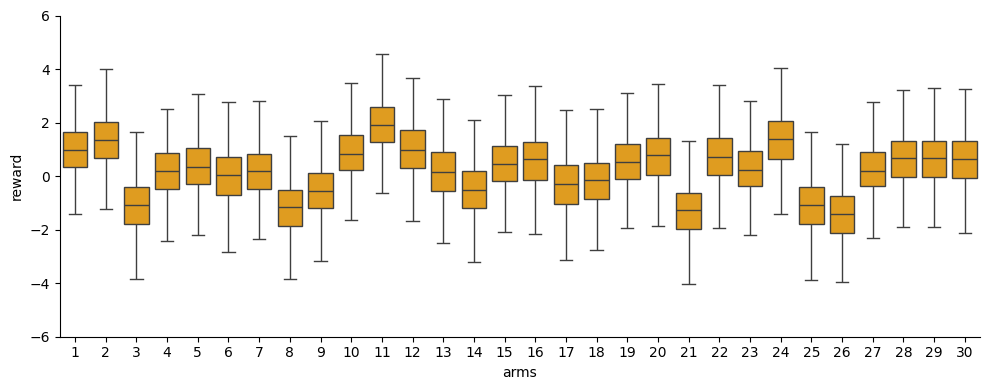

In [11]:
def animate(iter):
    global q_mu

    # plot
    ax.clear()
    ax.set_xticks(range(k_arms), range(1, k_arms+1))
    ax.set_xlabel("arms")
    ax.set_ylabel("reward")
    ax.set_ylim(-6, 6)
    # ax.set_title(f"Iter {iter}")
    
    viz_r_dist(k_arms, q_mu, N=1000, ax=ax)
    sns.despine()    
    plt.tight_layout()

    # random walk
    q_mu = random_walk_q(q_mu, std=q_delta_std)    


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
q_mu = init_q(k=k_arms, random_q_init=True, std=1)    
animate(1)

For this stationary reward problem, we show to the left below the moving average values (420 window) of the average reward over timesteps for the different algorithms. Here `eps=0` means Greedy, and `eps=0.1` means Epsilon-Greedy. `step_size = 1/N` means the algorithm uses sample-averaging, while `step_size = 0.1` means the algorithm uses weighted averaging with $\alpha = 0.1$ 

To the right, we show the proportion among all trials that the optimal action (corresponding to the highest true expected return $q(a)$) was selected.

**Observations**
* Worst performers
    * Greedy with weighted averaging (green)
    * Epsilon-Greedy with sample-averaging (orange)
* Best performers
    * Greedy with sample-averaging (blue)
    * Epsilon-Greedy with weighted averaging (red) which also got the highest percent optimal actions

**Questions (I don't know the answers to yet)**
* For Greedy, why does weighted averaging worsen performance while sample averaging improves performance?
* For Epsilon-Greedy, why does weighted averaging improve performance while sample averaging worsens performance?

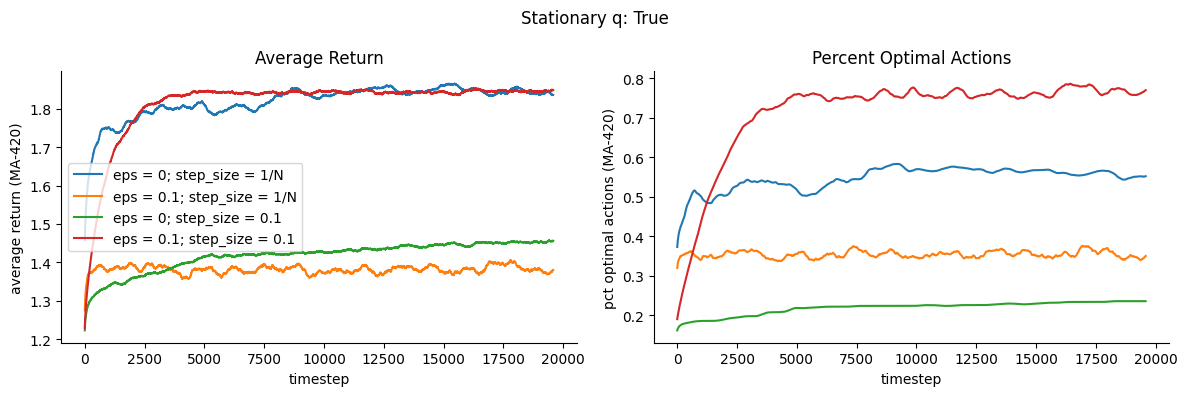

In [7]:
w = 420
stationary_q = True
random_q_init = True
step_sizes = ["1/N", 0.1]
eps_list = [0, 0.1]

plot_learning_curves(stationary_q, random_q_init, q_delta_std, step_sizes, eps_list)

### Non-stationary Problem

We show in the animation below an example of K randomly generated distributions that gradually change means over the course of the game.

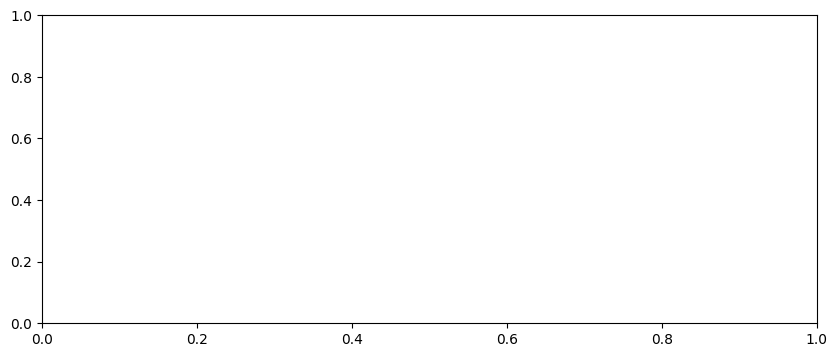

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

In [12]:
anim = animation.FuncAnimation(fig,
                               animate,
                               frames=100, 
                               interval=1)
HTML(anim.to_jshtml(fps=10))

<Figure size 640x480 with 0 Axes>

We show below the results for the stationary reward problem.

**Observations**
* Worst performers
    * Greedy with sample-averaging (blue)
    * Greedy with weighted averaging (green)
* Best performers
    * Epsilon-Greedy with weighted averaging(red)
    * Epsilon-Greedy with sample-averaging (orange) which also got the highest percent optimal actions
* For our non-stationary rewards problem, the Greedy algorithms perform poorly, while epsilon-Greedy performs well. This seems to indicate that exploration is key for changing our non-stationary problem.
* In this case, sample-averaging performs better than weighted averaging

**Questions (I don't know the answers to yet)**
* I expected weighted averaging to perform better since intuitively, this places more importance on more recent rewards, which change over time. But this is not what happens, why?
* Given the trajectory, maybe it just takes a while for weighted averaging method to keep up? What if we increase the number of timesteps?
* What exactly happens beneath the hood that explains the worse performance of the Greedy algorithms?

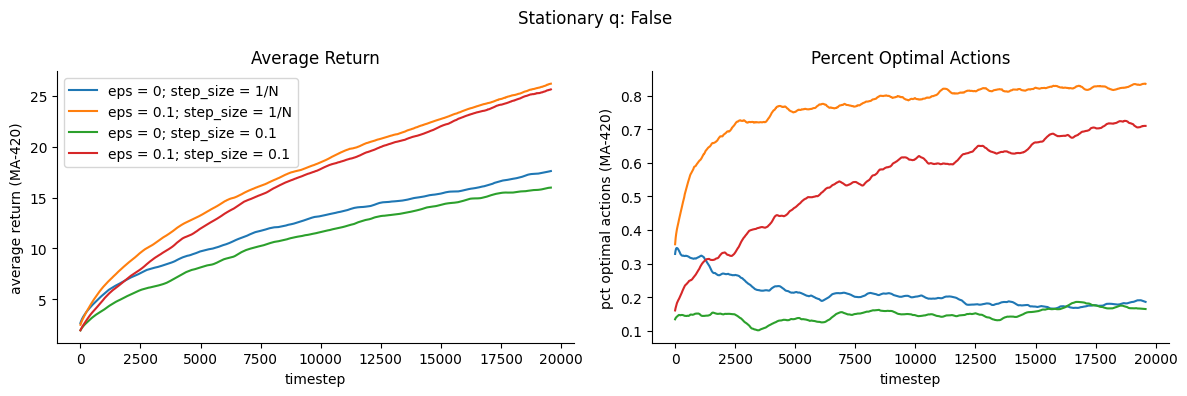

In [10]:
w = 420
stationary_q = False
random_q_init = True
step_sizes = ["1/N", 0.1]
eps_list = [0, 0.1]

plot_learning_curves(stationary_q, random_q_init, q_delta_std, step_sizes, eps_list)